In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [27]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = [dict(), dict(), dict()]
    att = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        if m == 'BirdFluxGraphLSTM':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_fluxes_*.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_mtr_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att

In [3]:
def compare_fluxes(radar_index, fluxes_model, fluxes_radar, trial=0, context=0):
    f_model = torch.cat([f for f in fluxes_model[trial].values()], dim=-1)
    f_model = f_model - f_model.permute(1, 0, 2)
    f_radar = torch.cat([f[..., context:] for f in fluxes_radar[trial].values()], dim=-1)
    
    f_model = f_model[radar_index]
    f_radar = f_radar[radar_index]
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(f_radar.view(-1).detach().numpy(), 
               f_model.view(-1).detach().numpy(), alpha=0.2)
    ax.set(xlabel='radar fluxes', ylabel='model fluxes');

In [23]:
def plot_fluxes(voronoi, G, all_fluxes, results, trial=0, encoder=0, context=0, bird_scale=1):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in all_fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results['BirdFluxGraphLSTM'].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[trial]))])


    radars = results['BirdFluxGraphLSTM'].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
                if not boundary1 and not boundary2:
                    print(ri, rj, val, val2)
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new

In [6]:
def plot_net_fluxes(voronoi, G, fluxes, results, trial=0, encoder=0, context=0, bird_scale=1):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results['BirdFluxGraphLSTM'].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results['BirdFluxGraphLSTM'].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val1 = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            val = val1 - val2
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                if val > 0 and not boundary1 and not boundary2:
                #if not boundary1 and not boundary2:
#                     print(val, val2)
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred net fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new

In [7]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

### With fixed boundary radars, with weighted fluxes

In [ ]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'fixed_boundary_without_dummy_radars_encoder_weighted_fluxes']
results0, bird_scales0, fluxes0, _ = load_results(models, experiments, base_dir)

In [ ]:
fig = utils.plot_average_errors(results0, boundary=boundary, night_only=True)

In [ ]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes0[0], results0, trial=0, encoder=1, bird_scale=bird_scales0['BirdFluxGraphLSTM'])

### Without dummy radars, with weighted fluxes, $c=1.0$

In [10]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_fluxmlp_without_dummy_radars_constrained_boundary_fluxes1_encoder_weighted_fluxes']
results1, bird_scales1, fluxes1, _ = load_results(models, experiments, base_dir)

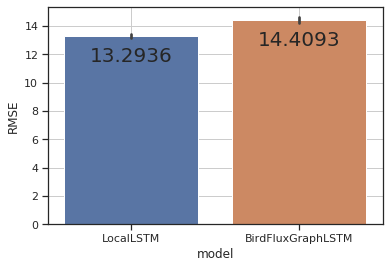

In [11]:
fig = utils.plot_average_errors(results1, boundary=boundary, night_only=True)

nldbl bezav 2.4225113e-07 0.0010278717
nldbl bejab 2.0059201e-07 0.00091847987
nldbl deess 0.0027591065 0.0011906682
nldbl deemd 4.3554718e-07 0.00088842266
nldbl nldhl 1.2385956e-07 0.0014517716
dehnr defld 0.003436188 0.0021102421
dehnr deess 0.0015274732 0.0014286588
dehnr deboo 6.2495707e-07 0.0026714185
dehnr deemd 1.7731467e-07 0.0022125794
dehnr deumd 0.0026207988 0.0029424424
deneu defld 0.0021031164 0.0020166347
deneu deeis 7.224243e-07 0.0018152903
deneu dedrs 7.993e-07 0.0019388883
deneu deoft 0.0024810114 0.002104839
deneu deumd 0.0016491757 0.0025822965
deneu detur 0.0011853583 0.0013870021
depro deumd 0.0022950012 5.3518664e-07
bezav nldbl 0.0010278717 2.4225113e-07
bezav denhb 0.0015047841 2.976041e-07
bezav deess 0.0018503398 2.7076936e-07
defld dehnr 0.0021102421 0.003436188
defld deneu 0.0020166347 0.0021031164
defld deess 0.002327358 0.0033367078
defld deoft 0.0030404883 0.0026063577
defld deumd 0.0014282475 0.0023511196
bejab nldbl 0.00091847987 2.0059201e-07
deros 

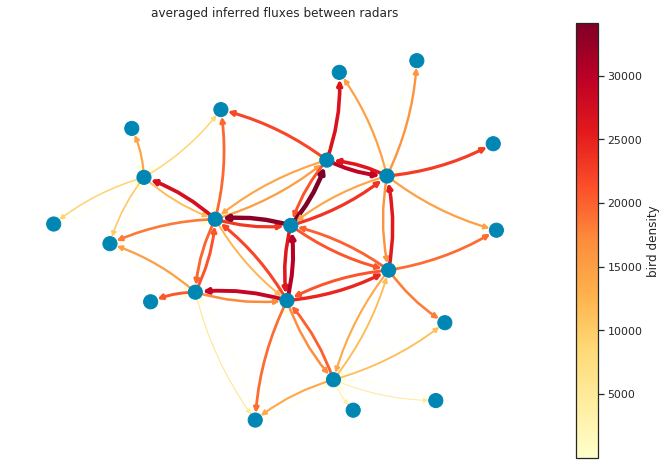

In [19]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes1[0], results1, trial=0, encoder=1, bird_scale=bird_scales1['BirdFluxGraphLSTM'])

In [ ]:
compare_fluxes(inner_radars, fluxes1[0], fluxes1[1], trial=0, context=24)

### Without dummy radars, without weighted fluxes, $c=1.0$

In [13]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM2']
experiments = ['encoder_km2',
              'boundary_fluxmlp_without_dummy_radars_constrained_boundary_fluxes1_encoder']
results2, bird_scales2, fluxes2, _ = load_results(models, experiments, base_dir)

IndexError: list index out of range

In [14]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

NameError: name 'results2' is not defined

In [ ]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scale=bird_scales2['BirdFluxGraphLSTM'])

In [ ]:
compare_fluxes(inner_radars, fluxes2[0], fluxes2[1], trial=0, context=24)

### With dummy radars, with weighted fluxes, $c=1.0$

In [29]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_fluxmlp_with_dummy_radars_constrained_boundary_fluxes1_encoder_weighted_fluxes']
results3, bird_scales3, fluxes3, _ = load_results(models, experiments, base_dir)

4


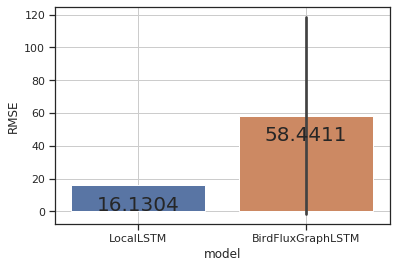

In [16]:
fig = utils.plot_average_errors(results3, boundary=[], night_only=True)

nldbl bezav -0.0078919185 -0.008760043
nldbl bejab 0.036267184 -0.0079296185
nldbl deess -0.047610793 -0.008278626
nldbl deemd 0.008834997 -0.0074163345
nldbl nldhl 0.017656857 -0.008894885
nldbl boundary_0 0.17551325 -0.00794974
dehnr defld -0.06431377 -0.05166481
dehnr deess -0.036446646 -0.04196177
dehnr deboo 0.016344145 -0.047802974
dehnr deemd 0.008482637 -0.04713032
dehnr deumd -0.033970464 -0.04981695
deneu defld -0.05727335 -0.040471304
deneu deeis 0.027284758 -0.042484064
deneu dedrs 0.019462649 -0.037924886
deneu deoft -0.04492321 -0.04217542
deneu deumd -0.03225291 -0.04055374
deneu detur -0.01796868 -0.037793197
depro deros 0.043217704 0.027318142
depro dedrs 0.019323375 0.028897708
depro deumd -0.029985955 0.028279379
depro boundary_5 0.2205261 0.028029202
depro boundary_6 0.2095004 0.025398184
bezav nldbl -0.008760043 -0.0078919185
bezav bejab 0.042429663 -0.008547417
bezav denhb -0.010578672 -0.0065689567
bezav deess -0.04344282 -0.006858319
bezav bewid 0.019780455 -0.0

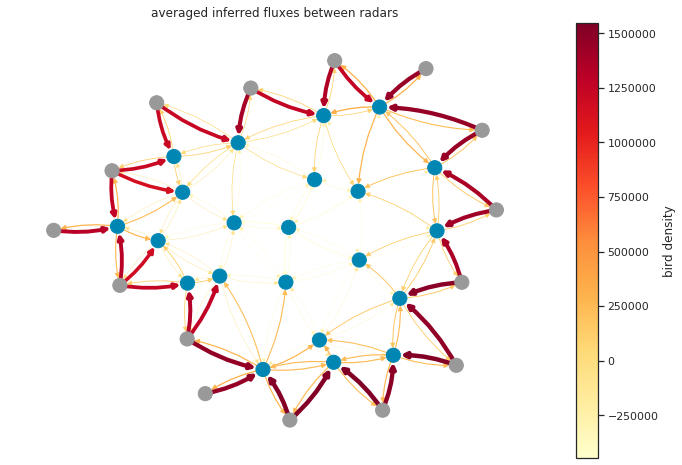

In [40]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes3[0], results3, trial=3, encoder=1, bird_scale=bird_scales3['BirdFluxGraphLSTM'])

nldbl bezav -0.010733793947904588 0.010733793947904592
nldbl bejab -0.0007476476333726392 0.0007476476333726391
nldbl deess 0.0027321226196147163 -0.0027321226196147163
nldbl deemd 0.0011664797968285743 -0.0011664797968285743
nldbl nldhl 0.0011495142144352375 -0.001149514214435234
nldbl boundary_0 -0.000945740192185645 0.000945740192185646
dehnr defld -0.008574432907925764 0.008574432907925764
dehnr deess -0.0006023749544213362 0.0006023749544213363
dehnr deboo 0.003994369374264542 -0.0039943693742645415
dehnr deemd -0.0007495784052392876 0.0007495784052392907
dehnr deumd 0.0032653458708152864 -0.003265345870815287
deneu defld -0.0027530398932298045 0.0027530398932298045
deneu deeis 0.0015700062052968532 -0.0015700062052968536
deneu dedrs 0.004746424466824787 -0.004746424466824787
deneu deoft -0.005834016747553875 0.005834016747553875
deneu deumd 0.003879666722870945 -0.003879666722870945
deneu detur -0.0017002960326816354 0.0017002960326816348
depro deros 0.0015334052437365009 -0.0015

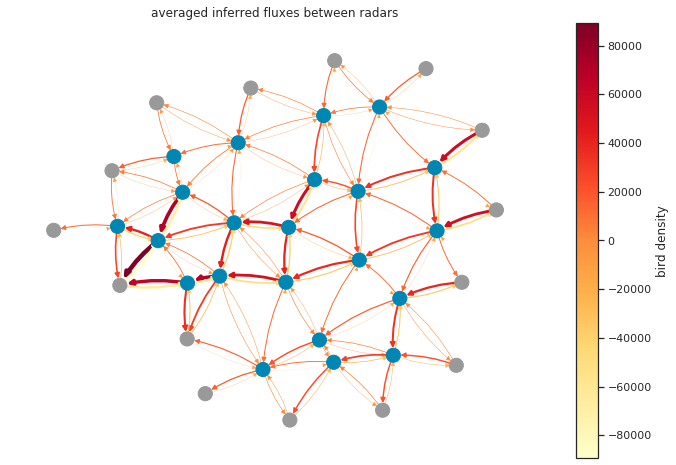

In [21]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes3[1], results3, trial=0, encoder=1, context=24, bird_scale=bird_scales3['BirdFluxGraphLSTM'])

In [ ]:
compare_fluxes(inner_radars, fluxes3[0], fluxes3[1], trial=0, context=24)